In [1]:
set.seed(100)
library(tidyverse)
library(readxl)
library(GGally)
library(rsample)
library(kernlab)
library(sos)

concrete <- read_xls("/Users/manoj/Desktop/7135CEM - Modelling and Optimisation Under Uncertainty/Concrete_Data.xls")
colnames(concrete)<- c( "cement",
                        "blast_furnace_slag",
                        "fly_ash",
                        "water",
                        "superplasticizer",
                        "coarse_aggregate",
                        "fine_aggregate",
                        "age",
                        "strength")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.3     v purrr   0.3.2
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'GGally' was built under R version 3.6.3"Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Warning message:
"package 'rsample' was built under R version 3.6.3"Warning message:
"package 'kernlab' was built under R version 3.6.3"
Attaching package: 'kernlab'

The fol

In [2]:
concrete %>%
filter(age==28)%>%
select(!age)->concrete

In [3]:
summary(concrete)

     cement      blast_furnace_slag    fly_ash           water      
 Min.   :102.0   Min.   :  0.00     Min.   :  0.00   Min.   :121.8  
 1st Qu.:160.2   1st Qu.:  0.00     1st Qu.:  0.00   1st Qu.:171.0  
 Median :261.0   Median : 94.70     Median : 60.00   Median :185.0  
 Mean   :265.4   Mean   : 86.28     Mean   : 62.79   Mean   :183.1  
 3rd Qu.:323.7   3rd Qu.:160.50     3rd Qu.:120.00   3rd Qu.:193.3  
 Max.   :540.0   Max.   :359.40     Max.   :200.10   Max.   :247.0  
 superplasticizer coarse_aggregate fine_aggregate     strength     
 Min.   : 0.000   Min.   : 801.0   Min.   :594.0   Min.   : 8.536  
 1st Qu.: 0.000   1st Qu.: 882.6   1st Qu.:712.0   1st Qu.:26.228  
 Median : 7.800   Median : 953.2   Median :769.3   Median :33.762  
 Mean   : 6.995   Mean   : 956.1   Mean   :764.4   Mean   :36.748  
 3rd Qu.:10.300   3rd Qu.:1013.2   3rd Qu.:811.5   3rd Qu.:44.388  
 Max.   :32.200   Max.   :1145.0   Max.   :992.6   Max.   :81.751  

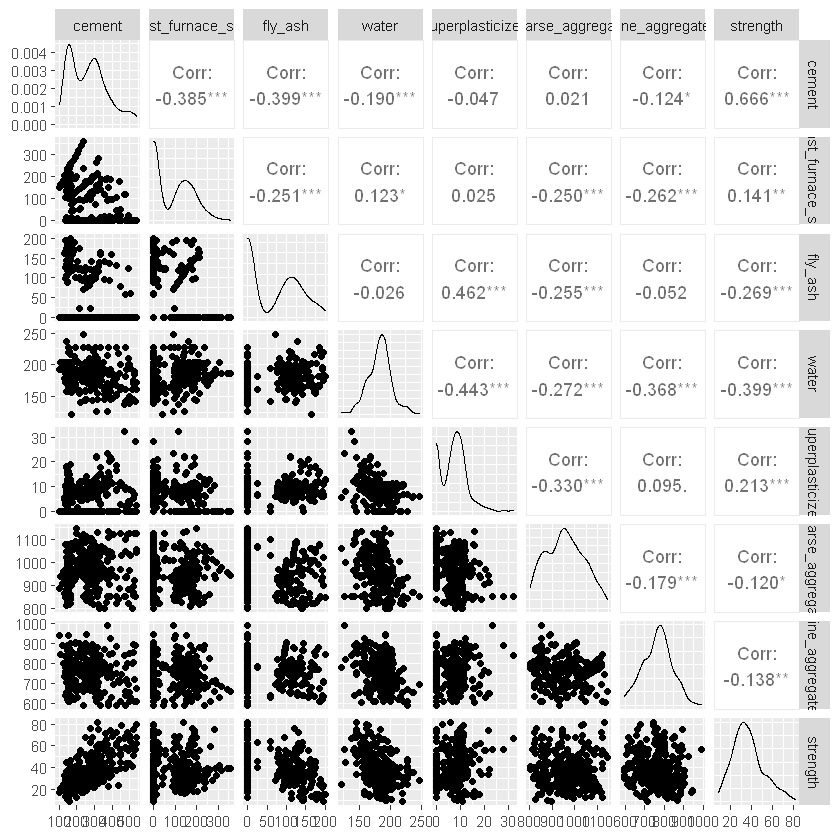

In [4]:
ggpairs(concrete)

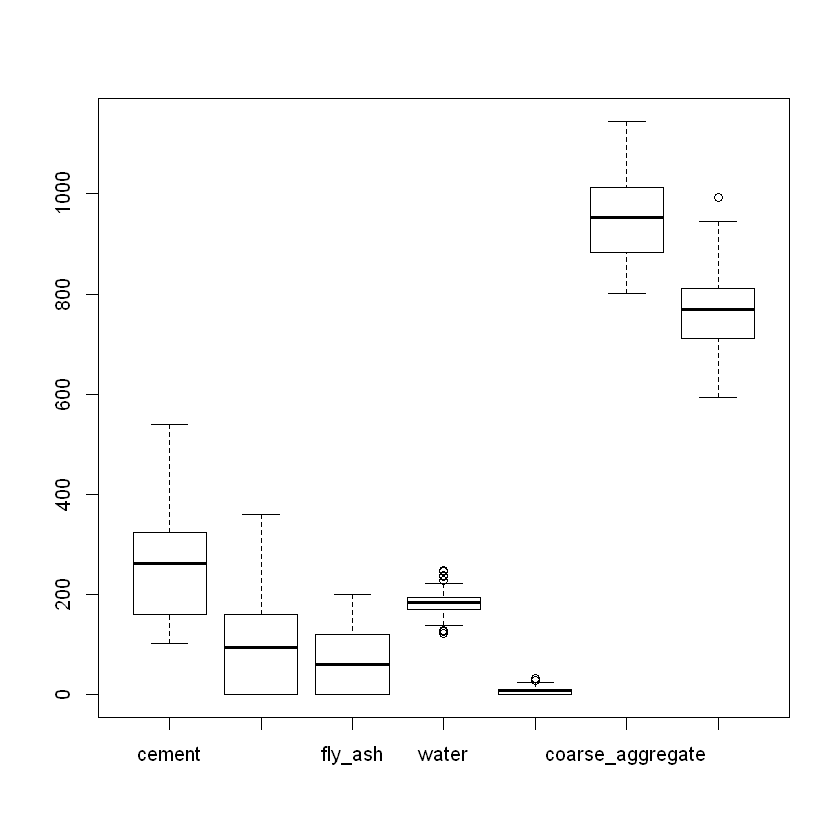

In [5]:
concrete %>%
select(!strength)%>%
boxplot()

In [6]:
set.seed(100)
split <- initial_split(concrete, prop = 0.7)
tr_sam<-split$in_id
ts_sam<-(1:nrow(concrete))[-split$in_id]
train <- training(split)
test <- testing(split)

In [7]:
lm_fit <- lm(strength ~ ., data = train)

gp_fit<- gausspr(strength ~ ., data = train)

Using automatic sigma estimation (sigest) for RBF or laplace kernel 


In [8]:
error_mes<-function(pred_df){
RMSE <- function(m, o){
  sqrt(mean((m - o)^2))
}

APE <- function(m, o){
  mean(abs((m - o)/m))
}

res_tab<-NULL

for(i in 1: (ncol(pred_df)-1)){
met<-c(round(RMSE(pred_df[,1],pred_df[,i+1]),2),
       round(APE(pred_df[,1],pred_df[,i+1]),2),
       round(cor(pred_df[,1],pred_df[,i+1]),2))
res_tab<-rbind(res_tab,met)
}
rownames(res_tab)<-colnames(pred_df)[-1]
colnames(res_tab)<-c("RMSE","APE","r")
return(res_tab)}



obs<-train$strength  
lm_pred <- lm_fit %>% predict(train  %>% select(!strength))
gp_pred <- gp_fit %>% predict(train  %>% select(!strength))

tr_pred<- data.frame( measure=obs,
                  MLR=lm_pred,
                  GP =gp_pred) 

obs<-test$strength  
lm_pred <- lm_fit %>% predict(test  %>% select(!strength))
gp_pred <- gp_fit %>% predict(test  %>% select(!strength))

ts_pred<- data.frame( measure=obs,
                  MLR=lm_pred,
                  GP =gp_pred) 



error_mes(tr_pred)

,RMSE,APE,r
MLR,6.71,0.14,0.89
GP,6.14,0.14,0.92


In [9]:
error_mes(ts_pred)

,RMSE,APE,r
MLR,7.85,0.18,0.83
GP,6.33,0.17,0.89


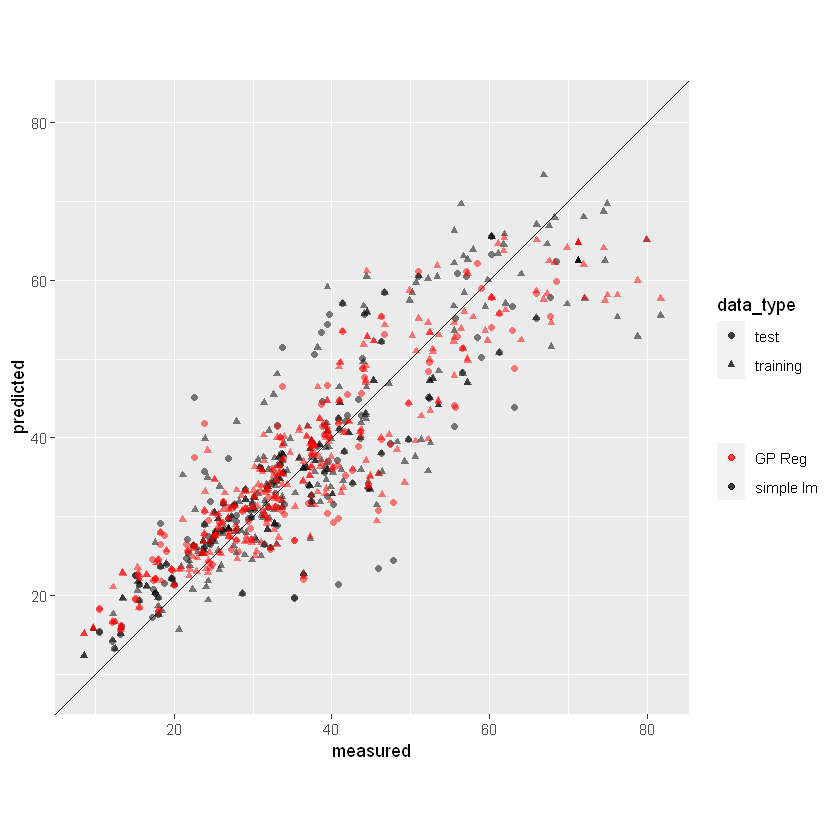

In [10]:
full_pred<-rbind(tr_pred %>% mutate(data_type="training"),
                  ts_pred %>% mutate(data_type="test"))


ggplot(full_pred, aes(x = measure)) +
  geom_abline(slope = 1, intercept = 0) +
  geom_point(aes(y = MLR, color = "simple lm",shape=data_type), alpha = 0.5) +
  geom_point(aes(y = GP, color = "GP Reg",shape=data_type), alpha = 0.5) +
   scale_colour_manual("", 
                      values = c("simple lm" = "black", "GP Reg" = "red")) +
  coord_cartesian(xlim = c(min(full_pred$measure), max(full_pred$measure)), ylim = c(min(full_pred$measure), max(full_pred$measure))) +
  ylab("predicted") +
  xlab("measured")+
  theme(aspect.ratio = 1) 